In [30]:
import sys
import pandas as pd
import numpy as np
from ISLP import load_data
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

In [11]:
df = load_data('Wage')
print("Cols & data types:")
print(df.dtypes)

print("\nFirst 5 rows:")
display(df.head())

print(f"dataset shape: {df.shape}\n ")

Cols & data types:
year             int64
age              int64
maritl        category
race          category
education     category
region        category
jobclass      category
health        category
health_ins    category
logwage        float64
wage           float64
dtype: object

First 5 rows:


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


dataset shape: (3000, 11)
 


## Part a
Split the data into training (70%) and testing (30%) data sets. Use seed 598 for reproducibility of the results.

In [22]:
#split features into categorical and numeric (for later preprocessing)
target = 'wage'
leakage = 'logwage'
feature_cols = [c for c in df.columns if c != target and c != leakage]

categorical_features = [c for c in feature_cols if df[c].dtype.name in ('object', 'category')]
numeric_features = [c for c in feature_cols if c not in categorical_features]

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)

Categorical: ['maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins']
Numeric: ['year', 'age']


In [23]:
#Train/test split
from sklearn.model_selection import train_test_split

X = df[feature_cols].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=598
)

print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (2100, 9), Test size: (900, 9)


In [24]:
print("Shapes:")
print("X train size:", X_train.shape, " y train size:", y_train.shape)
print("X test size :", X_test.shape,  " y test size :", y_test.shape)

Shapes:
X train size: (2100, 9)  y train size: (2100,)
X test size : (900, 9)  y test size : (900,)


## Part b
Fit a tree model and visualize it. Interpret at least two splits.

In [25]:
#preprocessing pipeline
#diffeent preprocessing for categorical and numeric features
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preproc = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical_features),
        ("num", "passthrough", numeric_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

#model pipeline with decision tree regressor
tree = DecisionTreeRegressor(random_state=598)
pipe_tree = Pipeline([
    ("prep", preproc),
    ("model", tree),
])

#fit and eval model
pipe_tree.fit(X_train, y_train)
y_pred = pipe_tree.predict(X_test)
test_mse_unpruned = mean_squared_error(y_test, y_pred)
print(f"b) unpruned decision tree test MSE: {test_mse_unpruned:,.2f}")

b) unpruned decision tree test MSE: 2,589.73


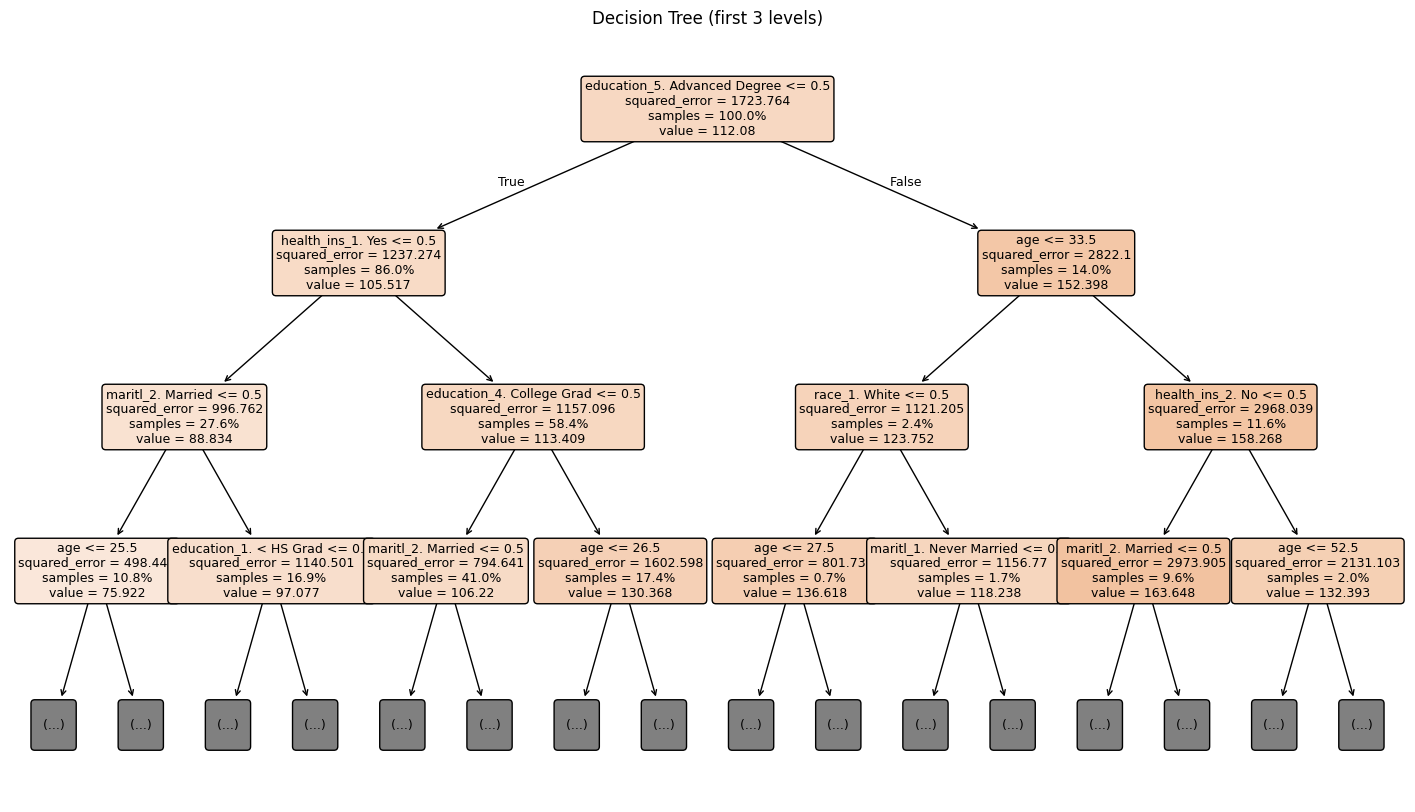

In [29]:
feature_names_out = pipe_tree.named_steps["prep"].get_feature_names_out()

plt.figure(figsize=(18, 10))
plot_tree(
    pipe_tree.named_steps["model"],
    feature_names=feature_names_out,
    filled=True,
    rounded=True,
    max_depth=3,
    impurity=True,
    proportion=True,
    fontsize=9
)
plt.title("Decision Tree (first 3 levels)")
plt.show()


### Split Interpretation

#### 1. Root split
We see that education level is the best separator between those with higher wages and lower wages. At the root, the decision tree decided to split based on education level. Since we have one hot vector encoded this feature (because it's categorical), we set 0 = non advanced degree and 1 = advanced degree. So the rule of advanced degree <= 0.5 is just True when the degree acheived is not advanced, and goes left, and is False when the degree is advanced and goes right. 

We can see from the samples variable that 86% of the dataset had no advanced degree, while 14% had an advanced degree. This means that education level is the strongest first separator, and that having an advanced degree is a good indicator of workers being in a higher wage group.

#### 2. First left split
We see that amongst those without advanced degrees, having health insurance has a strong correlation with higher wages. This is within the non advanced degree group. The next best indicator within this group that the decision tree model found was health insurance. This is the same case as education level with the one hot vector encoding, so 1 means has health insurance and 0 means does not have health insurance. So the rule of health insurance degree <= 0.5 is True when the worker does not have health insurance and goes left, and is False when the worker does have health insurance and goes right. 

We can see from the samples variable that 27.6% of the overall dataset had no health insurance (and no advanced education), while 58.4% of the overall dataset had health insurance (and no advanced eduacation). This means that amongst workers without advanced degrees, having health insurance has a strong correlation with higher wages, and those without insurance are in a lower wage branch.

## Part c

In [32]:
#build alpha grid from the pruning path
Xt_train = preproc.fit_transform(X_train)
tree0 = DecisionTreeRegressor(random_state=598)
tree0.fit(Xt_train, y_train)
path = tree0.cost_complexity_pruning_path(Xt_train, y_train)
alphas = np.unique(path.ccp_alphas)

#samole
idx = np.linspace(0, len(alphas)-1, num=min(25, len(alphas)), dtype=int)
alpha_grid = alphas[idx]

#cross validate ccp_alpha
pipe_for_cv = Pipeline([
    ("prep", clone(preproc)),
    ("model", DecisionTreeRegressor(random_state=598)),
])

#run gridsearch
cv = KFold(n_splits=5, shuffle=True, random_state=598)
grid = GridSearchCV(
    estimator=pipe_for_cv,
    param_grid={"model__ccp_alpha": alpha_grid},
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
)
grid.fit(X_train, y_train)

best_alpha = float(grid.best_params_["model__ccp_alpha"])
best_cv_mse = -grid.best_score_

#Fit unpruned vs pruned on train set, eval on test
pipe_unpruned = Pipeline([
    ("prep", clone(preproc)),
    ("model", DecisionTreeRegressor(random_state=598)),
])
pipe_unpruned.fit(X_train, y_train)
test_mse_unpruned = mean_squared_error(y_test, pipe_unpruned.predict(X_test))

pipe_pruned = Pipeline([
    ("prep", clone(preproc)),
    ("model", DecisionTreeRegressor(random_state=598, ccp_alpha=best_alpha)),
])
pipe_pruned.fit(X_train, y_train)
test_mse_pruned = mean_squared_error(y_test, pipe_pruned.predict(X_test))

In [38]:
print(f"Best ccp_alpha: {best_alpha:.6g}")
print(f"Cross Validation MSE at best alpha: {best_cv_mse:,.2f}")
print(f"\nTest MSE for unpruned: ${test_mse_unpruned:,.2f}")
print(f"Test MSE for pruned: ${test_mse_pruned:,.2f}")
print(f"\nTest RMSE for unpruned: ${np.sqrt(test_mse_unpruned):,.2f}")
print(f"Test RMSE for pruned: ${np.sqrt(test_mse_pruned):,.2f}")

impr = 100 * (test_mse_unpruned - test_mse_pruned) / test_mse_unpruned
print(f"\nImprovement from pruning: {impr:.2f}%")

Best ccp_alpha: 264.615
Cross Validation MSE at best alpha: 1,642.72

Test MSE for unpruned: $2,589.73
Test MSE for pruned: $1,780.67

Test RMSE for unpruned: $50.89
Test RMSE for pruned: $42.20

Improvement from pruning: 31.24%


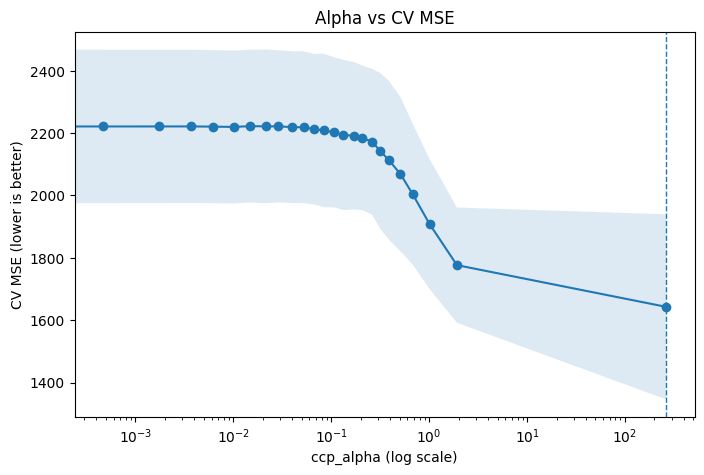

In [ ]:
#alpha vs CV MSE
means = -grid.cv_results_["mean_test_score"]
stds  = grid.cv_results_["std_test_score"]
alph  = grid.cv_results_["param_model__ccp_alpha"].data.astype(float)

plt.figure(figsize=(8,5))
plt.semilogx(alph, means, marker="o")
plt.fill_between(alph, means - stds, means + stds, alpha=0.15)
plt.axvline(best_alpha, ls="--", lw=1)
plt.xlabel("ccp_alpha (log scale)")
plt.ylabel("CV MSE")
plt.title("Alpha vs CV MSE")
plt.show()


#### Conclusion on pruned vs. unpruned

Pruning substantially improved the model and generalization. On the test set, MSE dropped from $2,589.73 to $1,780.67, which is a 31.24% reduction. The RMSE change was from $50.89 to $42.20, which is about an $8.69 difference. So from this, we can determine that the pruned tree’s wage error is around $8-9 lower than the unpruned tree’s wage error.

The ccp_alpha vs. CV MSE graph clearly shows how pruning is better, because as pruning strength increases, the CV MSE falls, hitting its lowest at ccp_alpha = 264.615. This indicates the unpruned tree was overfitting, and simplifying the tree reduces error on unseen data without introducing too much bias.

In [ ]:
# Step 5: Random Forest Models

In [ ]:
# Step 6: Identify Important Predictors

In [ ]:
# Step 7: Compare Random Forest and Pruned Tree

In [ ]:
# Step 8: Gradient Boosting Machine
